In [83]:
import time
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import deepchem as dc
from deepchem.feat import ConvMolFeaturizer, CircularFingerprint
from deepchem.models import GraphConvModel
from deepchem.models.optimizers import Adam
import logging
from sklearn.metrics import r2_score, mean_absolute_error
from chembl_webresource_client.new_client import new_client
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from requests.exceptions import RequestException


In [86]:
 # Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class AffinityPredictor:
    def __init__(self):
        self.graph_featurizer = ConvMolFeaturizer(per_atom_fragmentation=False)
        self.fingerprint_featurizer = CircularFingerprint(size=1024)
        self.scaler = StandardScaler()
        self.dataset_df = None
        self.graph_data = None
        self.fingerprint_data = None
        self.graph_model = None
        self.fingerprint_model = None
        self.ensemble_model = None
        self.metrics = {
            'graph': {'r2': -1, 'mae': -1},
            'fingerprint': {'r2': -1, 'mae': -1},
            'ensemble': {'r2': -1, 'mae': -1},
            'training_time': {}
        }

    def load_data(self, local_path='bace.csv', chembl_cache='chembl_cache.csv', use_chembl=True):
        """Load and preprocess data with robust error handling and caching"""
        logger.info("Loading and preprocessing data...")
        try:
            bace_df = pd.read_csv(local_path)
            bace_df = bace_df.rename(columns={'mol': 'smiles'})[['smiles', 'pIC50']].dropna()
            logger.info(f"Loaded {len(bace_df)} local compounds")
        except Exception as e:
            logger.error(f"Failed to load local data: {str(e)}")
            bace_df = pd.DataFrame(columns=['smiles', 'pIC50'])

        chembl_df = pd.DataFrame(columns=['smiles', 'pIC50'])
        if use_chembl:
            if os.path.exists(chembl_cache):
                try:
                    chembl_df = pd.read_csv(chembl_cache)
                    logger.info(f"Loaded {len(chembl_df)} cached ChEMBL compounds from {chembl_cache}")
                except Exception as e:
                    logger.warning(f"Failed to load cached ChEMBL data: {str(e)}")
            if len(chembl_df) == 0:
                try:
                    logger.info("Attempting to download ChEMBL data...")
                    activities = new_client.activity.filter(target_chembl_id="CHEMBL234").filter(standard_type="IC50")
                    start_time = time.time()
                    timeout = 30
                    chembl_data = []
                    for activity in activities:
                        if time.time() - start_time > timeout:
                            raise RequestException("ChEMBL request timed out")
                        chembl_data.append(activity)
                    chembl_df = pd.DataFrame(chembl_data)[['canonical_smiles', 'standard_value']].dropna()
                    chembl_df['standard_value'] = pd.to_numeric(chembl_df['standard_value'], errors='coerce')
                    chembl_df = chembl_df.dropna()
                    chembl_df['pIC50'] = -np.log10(chembl_df['standard_value'] * 1e-9)
                    chembl_df = chembl_df.rename(columns={'canonical_smiles': 'smiles'})[['smiles', 'pIC50']]
                    try:
                        chembl_df.to_csv(chembl_cache, index=False)
                        logger.info(f"Saved {len(chembl_df)} ChEMBL compounds to cache at {chembl_cache}")
                    except Exception as e:
                        logger.warning(f"Failed to save ChEMBL cache: {str(e)}")
                    logger.info(f"Downloaded {len(chembl_df)} ChEMBL compounds")
                except RequestException as e:
                    logger.warning(f"Network error accessing ChEMBL: {str(e)}")
                    logger.warning("Proceeding with available data")
                except Exception as e:
                    logger.warning(f"ChEMBL download failed: {str(e)}")
                    logger.warning("Proceeding with available data")

        full_df = pd.concat([bace_df, chembl_df], ignore_index=True).drop_duplicates(subset='smiles')
        valid_data = []
        for _, row in full_df.iterrows():
            try:
                mol = Chem.MolFromSmiles(row['smiles'])
                if mol and not np.isinf(row['pIC50']) and not np.isnan(row['pIC50']):
                    valid_data.append({
                        'smiles': row['smiles'],
                        'pIC50': float(row['pIC50']),
                        'mol': mol
                    })
            except Exception as e:
                logger.debug(f"Failed to process SMILES {row['smiles']}: {str(e)}")
                continue
        if not valid_data:
            raise ValueError("No valid molecules found in dataset")
        self.dataset_df = pd.DataFrame(valid_data)
        try:
            self.dataset_df['pIC50_scaled'] = self.scaler.fit_transform(
                self.dataset_df[['pIC50']].values).flatten()
        except Exception as e:
            logger.error(f"Scaling failed: {str(e)}")
            raise
        logger.info(f"Final dataset: {len(self.dataset_df)} compounds")
        logger.info(f"pIC50 stats - Mean: {self.dataset_df['pIC50'].mean():.2f}, "
                   f"Std: {self.dataset_df['pIC50'].std():.2f}, "
                   f"Range: {self.dataset_df['pIC50'].min():.2f}-{self.dataset_df['pIC50'].max():.2f}")
        mols = self.dataset_df['mol'].tolist()
        smiles_list = self.dataset_df['smiles'].tolist()
        y = self.dataset_df['pIC50_scaled'].values
        try:
            logger.info("Creating graph features...")
            graph_features = self.graph_featurizer.featurize(mols)
            self.graph_data = dc.data.NumpyDataset(X=graph_features, y=y)
            logger.info(f"Graph features created for {len(graph_features)} molecules")
        except Exception as e:
            logger.error(f"Graph featurization failed: {str(e)}")
            raise
        try:
            logger.info("Creating fingerprint features...")
            fingerprint_features = self.fingerprint_featurizer.featurize(smiles_list)
            self.fingerprint_data = dc.data.NumpyDataset(X=fingerprint_features, y=y)
            logger.info(f"Fingerprint features created: {fingerprint_features.shape}")
        except Exception as e:
            logger.error(f"Fingerprint featurization failed: {str(e)}")
            raise

    def build_graph_model(self):
        return GraphConvModel(
            n_tasks=1,
            graph_conv_layers=[128, 128],
            dense_layer_size=256,
            dropout=0.2,
            batch_size=32,
            learning_rate=0.001,
            mode='regression',
            optimizer=Adam(learning_rate=0.001),
            model_dir='./graph_model',
            tensorboard=True
        )

    def train_and_evaluate(self):
        if len(self.dataset_df) < 100:
            raise ValueError("Insufficient data for training (need at least 100 samples)")
        train_idx, test_idx = train_test_split(
            range(len(self.dataset_df)),
            test_size=0.2,
            random_state=42
        )
        train_idx, valid_idx = train_test_split(
            train_idx,
            test_size=0.2,
            random_state=42
        )
        g_train = dc.data.NumpyDataset(
            X=self.graph_data.X[train_idx],
            y=self.graph_data.y[train_idx]
        )
        g_valid = dc.data.NumpyDataset(
            X=self.graph_data.X[valid_idx],
            y=self.graph_data.y[valid_idx]
        )
        g_test = dc.data.NumpyDataset(
            X=self.graph_data.X[test_idx],
            y=self.graph_data.y[test_idx]
        )
        f_train = dc.data.NumpyDataset(
            X=self.fingerprint_data.X[train_idx],
            y=self.fingerprint_data.y[train_idx]
        )
        f_valid = dc.data.NumpyDataset(
            X=self.fingerprint_data.X[valid_idx],
            y=self.fingerprint_data.y[valid_idx]
        )
        f_test = dc.data.NumpyDataset(
            X=self.fingerprint_data.X[test_idx],
            y=self.fingerprint_data.y[test_idx]
        )
        logger.info(f"\nDataset sizes:")
        logger.info(f"Training: {len(train_idx)}")
        logger.info(f"Validation: {len(valid_idx)}")
        logger.info(f"Test: {len(test_idx)}")
        logger.info("\nTraining GraphConv model...")
        self.graph_model = self.build_graph_model()
        start_time = time.time()
        metric = dc.metrics.Metric(dc.metrics.r2_score)
        validation_callback = dc.models.ValidationCallback(
            g_valid,
            5,
            [metric],
            save_dir='./graph_model_best',
            save_on_minimum=False
        )
        self.graph_model.fit(g_train, nb_epoch=50, callbacks=[validation_callback])
        test_pred = self.graph_model.predict(g_test)
        self.metrics['graph']['r2'] = r2_score(g_test.y, test_pred)
        self.metrics['graph']['mae'] = mean_absolute_error(g_test.y, test_pred)
        self.metrics['training_time']['graph'] = time.time() - start_time
        logger.info(f"Graph Model Test R²: {self.metrics['graph']['r2']:.3f}")
        logger.info(f"Graph Model Test MAE: {self.metrics['graph']['mae']:.3f}")
        logger.info("\nTraining Fingerprint model...")
        start_time = time.time()
        self.fingerprint_model = make_pipeline(
            SimpleImputer(strategy='median'),
            RandomForestRegressor(
                n_estimators=200,
                max_depth=10,
                min_samples_split=5,
                n_jobs=-1,
                random_state=42
            )
        )
        self.fingerprint_model.fit(f_train.X, f_train.y.flatten())
        test_pred = self.fingerprint_model.predict(f_test.X)
        self.metrics['fingerprint']['r2'] = r2_score(f_test.y, test_pred)
        self.metrics['fingerprint']['mae'] = mean_absolute_error(f_test.y, test_pred)
        self.metrics['training_time']['fingerprint'] = time.time() - start_time
        logger.info(f"Fingerprint Model Test R²: {self.metrics['fingerprint']['r2']:.3f}")
        logger.info(f"Fingerprint Model Test MAE: {self.metrics['fingerprint']['mae']:.3f}")
        logger.info("\nBuilding ensemble model...")
        try:
            train_graph_pred = self.graph_model.predict(g_train).flatten()
            train_fp_pred = self.fingerprint_model.predict(f_train.X).flatten()
            X_train = np.column_stack([
                train_graph_pred,
                train_fp_pred,
                np.array([Descriptors.MolWt(mol) for mol in self.dataset_df.iloc[train_idx]['mol']])
            ])
            self.ensemble_model = make_pipeline(
                StandardScaler(),
                RandomForestRegressor(
                    n_estimators=150,
                    max_depth=8,
                    min_samples_split=5,
                    n_jobs=-1,
                    random_state=42
                )
            )
            self.ensemble_model.fit(X_train, g_train.y.flatten())
            test_graph_pred = self.graph_model.predict(g_test).flatten()
            test_fp_pred = self.fingerprint_model.predict(f_test.X).flatten()
            X_test = np.column_stack([
                test_graph_pred,
                test_fp_pred,
                np.array([Descriptors.MolWt(mol) for mol in self.dataset_df.iloc[test_idx]['mol']])
            ])
            ensemble_pred = self.ensemble_model.predict(X_test)
            self.metrics['ensemble']['r2'] = r2_score(g_test.y, ensemble_pred)
            self.metrics['ensemble']['mae'] = mean_absolute_error(g_test.y, ensemble_pred)
            logger.info(f"Ensemble Test R²: {self.metrics['ensemble']['r2']:.3f}")
            logger.info(f"Ensemble Test MAE: {self.metrics['ensemble']['mae']:.3f}")
            self._plot_predictions(g_test.y, ensemble_pred, "Ensemble Predictions")
        except Exception as e:
            logger.error(f"Ensemble training failed: {str(e)}")
            raise

    def _plot_predictions(self, y_true, y_pred, title):
        plt.figure(figsize=(8, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
        plt.xlabel('True pIC50 (scaled)')
        plt.ylabel('Predicted pIC50 (scaled)')
        plt.title(title)
        plt.grid(True)
        plt.savefig('predictions_plot.png')
        plt.show()

    def predict(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if not mol:
                raise ValueError("Invalid SMILES string")
            graph_feat = self.graph_featurizer.featurize([mol])
            graph_pred = self.graph_model.predict(dc.data.NumpyDataset(graph_feat))[0][0]
            fp_feat = self.fingerprint_featurizer.featurize([smiles])
            fp_pred = self.fingerprint_model.predict(fp_feat)[0]
            ensemble_input = np.array([[
                graph_pred,
                fp_pred,
                Descriptors.MolWt(mol)
            ]])
            scaled_pred = self.ensemble_model.predict(ensemble_input)[0]
            original_pred = self.scaler.inverse_transform([[scaled_pred]])[0][0]
            ic50 = 10**(-original_pred) * 1e9
            confidence = max(0.1, 1 - min(1, abs(graph_pred - fp_pred)/2))
            return {
                'pIC50': original_pred,
                'IC50_nM': ic50,
                'confidence': confidence,
                'graph_pred': self.scaler.inverse_transform([[graph_pred]])[0][0],
                'fingerprint_pred': self.scaler.inverse_transform([[fp_pred]])[0][0]
            }
        except Exception as e:
            logger.error(f"Prediction failed: {str(e)}")
            return {
                'error': str(e),
                'pIC50': None,
                'IC50_nM': None,
                'confidence': 0
            }

    def interactive_predict(self):
        print("\n=== BACE1 Affinity Prediction ===")
        print("Enter SMILES strings or 'quit' to exit\n")
        while True:
            smiles = input("SMILES: ").strip()
            if smiles.lower() in ('quit', 'exit'):
                break
            result = self.predict(smiles)
            if 'error' in result:
                print(f"\nError: {result['error']}\n")
                continue
            print("\nPrediction Results:")
            print(f"- Ensemble pIC50: {result['pIC50']:.2f}")
            print(f"- Estimated IC50: {result['IC50_nM']:.2f} nM")
            print(f"- Confidence: {result['confidence']*100:.0f}%")
            print(f"- GraphConv pIC50: {result['graph_pred']:.2f}")
            print(f"- Fingerprint pIC50: {result['fingerprint_pred']:.2f}")
            if hasattr(self, 'dataset_df') and self.dataset_df is not None:
                known = self.dataset_df[self.dataset_df['smiles'] == smiles]
                if not known.empty:
                    known_pic50 = known.iloc[0]['pIC50']
                    print(f"\nKnown pIC50: {known_pic50:.2f} (Error: {abs(known_pic50 - result['pIC50']):.2f})")
            print()

    def report(self):
        if not hasattr(self, 'metrics'):
            print("No training metrics available")
            return
        print("\n=== Model Performance Report ===")
        if hasattr(self, 'dataset_df') and self.dataset_df is not None:
            print(f"\nDataset Size: {len(self.dataset_df)} compounds")
            print(f"pIC50 Range: {self.dataset_df['pIC50'].min():.2f} to {self.dataset_df['pIC50'].max():.2f}")
        print("\nModel Performance:")
        print("GraphConv Model:")
        print(f"- R²: {self.metrics['graph']['r2']:.3f}")
        print(f"- MAE: {self.metrics['graph']['mae']:.3f}")
        print(f"- Training Time: {self.metrics['training_time'].get('graph', 'N/A')}s")
        print("\nFingerprint Model:")
        print(f"- R²: {self.metrics['fingerprint']['r2']:.3f}")
        print(f"- MAE: {self.metrics['fingerprint']['mae']:.3f}")
        print(f"- Training Time: {self.metrics['training_time'].get('fingerprint', 'N/A')}s")
        print("\nEnsemble Model:")
        print(f"- R²: {self.metrics['ensemble']['r2']:.3f}")
        print(f"- MAE: {self.metrics['ensemble']['mae']:.3f}")

2025-05-19 14:54:35,212 - INFO - Starting data loading...
2025-05-19 14:54:35,214 - INFO - Loading and preprocessing data...
2025-05-19 14:54:35,479 - INFO - Loaded 1513 local compounds
2025-05-19 14:54:35,481 - INFO - Attempting to download ChEMBL data...
2025-05-19 14:54:35,490 - INFO - https://www.ebi.ac.uk/chembl/api/data/activity.json
2025-05-19 14:54:35,491 - INFO - [('target_chembl_id', 'CHEMBL234'), ('standard_type', 'IC50'), ('limit', 20), ('offset', 0)]
2025-05-19 14:54:35,492 - INFO - From cache: True
2025-05-19 14:54:35,498 - INFO - https://www.ebi.ac.uk/chembl/api/data/activity.json
2025-05-19 14:54:35,499 - INFO - [('target_chembl_id', 'CHEMBL234'), ('standard_type', 'IC50'), ('limit', 20), ('offset', 20)]
2025-05-19 14:54:35,499 - INFO - From cache: True
2025-05-19 14:54:35,505 - INFO - https://www.ebi.ac.uk/chembl/api/data/activity.json
2025-05-19 14:54:35,505 - INFO - [('target_chembl_id', 'CHEMBL234'), ('standard_type', 'IC50'), ('limit', 20), ('offset', 40)]
2025-05-

Step 5 validation: r2_score=-5.52434


2025-05-19 14:55:21,370 - INFO - computed_metrics: [-8.297091414024369]


Step 10 validation: r2_score=-8.29709


2025-05-19 14:55:21,756 - INFO - computed_metrics: [-5.83898902548734]


Step 15 validation: r2_score=-5.83899


2025-05-19 14:55:22,145 - INFO - computed_metrics: [-2.568433001144057]


Step 20 validation: r2_score=-2.56843


2025-05-19 14:55:22,757 - INFO - computed_metrics: [-1.1251426739172232]


Step 25 validation: r2_score=-1.12514


2025-05-19 14:55:23,247 - INFO - computed_metrics: [-0.6276155177044545]


Step 30 validation: r2_score=-0.627616


2025-05-19 14:55:23,763 - INFO - computed_metrics: [-0.5407624877211521]


Step 35 validation: r2_score=-0.540762


2025-05-19 14:55:24,215 - INFO - computed_metrics: [-0.7409220689210407]


Step 40 validation: r2_score=-0.740922


2025-05-19 14:55:24,537 - INFO - computed_metrics: [-0.7856558120587143]


Step 45 validation: r2_score=-0.785656


2025-05-19 14:55:24,822 - INFO - computed_metrics: [-0.5565775542071507]


Step 50 validation: r2_score=-0.556578


2025-05-19 14:55:25,092 - INFO - computed_metrics: [-0.3514086942122452]


Step 55 validation: r2_score=-0.351409


2025-05-19 14:55:25,444 - INFO - computed_metrics: [-0.17965175408736478]


Step 60 validation: r2_score=-0.179652


2025-05-19 14:55:25,831 - INFO - computed_metrics: [-0.09913714588205291]


Step 65 validation: r2_score=-0.0991371


2025-05-19 14:55:26,236 - INFO - computed_metrics: [0.030328003381297153]


Step 70 validation: r2_score=0.030328


2025-05-19 14:55:26,650 - INFO - computed_metrics: [0.11738261055524779]


Step 75 validation: r2_score=0.117383


2025-05-19 14:55:27,071 - INFO - computed_metrics: [0.10785881937053121]


Step 80 validation: r2_score=0.107859


2025-05-19 14:55:27,394 - INFO - computed_metrics: [0.14493930741988337]


Step 85 validation: r2_score=0.144939


2025-05-19 14:55:27,830 - INFO - computed_metrics: [0.1579324167616717]


Step 90 validation: r2_score=0.157932


2025-05-19 14:55:28,175 - INFO - computed_metrics: [0.24532078283840475]


Step 95 validation: r2_score=0.245321


2025-05-19 14:55:28,461 - INFO - Ending global_step 100: Average loss 1.15249
2025-05-19 14:55:28,537 - INFO - computed_metrics: [0.1601576721494684]


Step 100 validation: r2_score=0.160158


2025-05-19 14:55:28,816 - INFO - computed_metrics: [0.19375711466613044]


Step 105 validation: r2_score=0.193757


2025-05-19 14:55:29,083 - INFO - computed_metrics: [0.18172544807438973]


Step 110 validation: r2_score=0.181725


2025-05-19 14:55:29,336 - INFO - computed_metrics: [0.18479557685534798]


Step 115 validation: r2_score=0.184796


2025-05-19 14:55:29,606 - INFO - computed_metrics: [0.22279261242257564]


Step 120 validation: r2_score=0.222793


2025-05-19 14:55:29,853 - INFO - computed_metrics: [0.24579477132074035]


Step 125 validation: r2_score=0.245795


2025-05-19 14:55:30,222 - INFO - computed_metrics: [0.24645089214552063]


Step 130 validation: r2_score=0.246451


2025-05-19 14:55:30,576 - INFO - computed_metrics: [0.24621205566784976]


Step 135 validation: r2_score=0.246212


2025-05-19 14:55:30,826 - INFO - computed_metrics: [0.2560728313158631]


Step 140 validation: r2_score=0.256073


2025-05-19 14:55:31,222 - INFO - computed_metrics: [0.24569141211276457]


Step 145 validation: r2_score=0.245691


2025-05-19 14:55:31,471 - INFO - computed_metrics: [0.23372841110027398]


Step 150 validation: r2_score=0.233728


2025-05-19 14:55:31,748 - INFO - computed_metrics: [0.2048929508133841]


Step 155 validation: r2_score=0.204893


2025-05-19 14:55:31,999 - INFO - computed_metrics: [0.20202514442003527]


Step 160 validation: r2_score=0.202025


2025-05-19 14:55:32,262 - INFO - computed_metrics: [0.15990209001289857]


Step 165 validation: r2_score=0.159902


2025-05-19 14:55:32,490 - INFO - computed_metrics: [0.13140720966546715]


Step 170 validation: r2_score=0.131407


2025-05-19 14:55:32,733 - INFO - computed_metrics: [0.11319992367381393]


Step 175 validation: r2_score=0.1132


2025-05-19 14:55:33,004 - INFO - computed_metrics: [0.17042956807845455]


Step 180 validation: r2_score=0.17043


2025-05-19 14:55:33,251 - INFO - computed_metrics: [0.17986136329681301]


Step 185 validation: r2_score=0.179861


2025-05-19 14:55:33,534 - INFO - computed_metrics: [0.1784846760533787]


Step 190 validation: r2_score=0.178485


2025-05-19 14:55:33,808 - INFO - computed_metrics: [0.16464713676811205]


Step 195 validation: r2_score=0.164647


2025-05-19 14:55:34,033 - INFO - Ending global_step 200: Average loss 0.682632
2025-05-19 14:55:34,136 - INFO - computed_metrics: [0.17343269078048107]


Step 200 validation: r2_score=0.173433


2025-05-19 14:55:34,452 - INFO - computed_metrics: [0.1915694067554259]


Step 205 validation: r2_score=0.191569


2025-05-19 14:55:34,742 - INFO - computed_metrics: [0.24667329103943247]


Step 210 validation: r2_score=0.246673


2025-05-19 14:55:35,111 - INFO - computed_metrics: [0.21394586963525042]


Step 215 validation: r2_score=0.213946


2025-05-19 14:55:35,437 - INFO - computed_metrics: [0.15857953263144942]


Step 220 validation: r2_score=0.15858


2025-05-19 14:55:35,897 - INFO - computed_metrics: [0.059300622589073315]


Step 225 validation: r2_score=0.0593006


2025-05-19 14:55:36,200 - INFO - computed_metrics: [0.11867362628705291]


Step 230 validation: r2_score=0.118674


2025-05-19 14:55:36,509 - INFO - computed_metrics: [0.22503453859908684]


Step 235 validation: r2_score=0.225035


2025-05-19 14:55:36,838 - INFO - computed_metrics: [0.21305470273071314]


Step 240 validation: r2_score=0.213055


2025-05-19 14:55:37,183 - INFO - computed_metrics: [0.13996811949763832]


Step 245 validation: r2_score=0.139968


2025-05-19 14:55:37,470 - INFO - computed_metrics: [0.08530541857744156]


Step 250 validation: r2_score=0.0853054


2025-05-19 14:55:37,762 - INFO - computed_metrics: [0.18582240325295007]


Step 255 validation: r2_score=0.185822


2025-05-19 14:55:38,069 - INFO - computed_metrics: [0.2047989433090922]


Step 260 validation: r2_score=0.204799


2025-05-19 14:55:38,432 - INFO - computed_metrics: [0.20561620041740836]


Step 265 validation: r2_score=0.205616


2025-05-19 14:55:38,746 - INFO - computed_metrics: [0.21733417411446931]


Step 270 validation: r2_score=0.217334


2025-05-19 14:55:39,018 - INFO - computed_metrics: [0.2501193565017117]


Step 275 validation: r2_score=0.250119


2025-05-19 14:55:39,311 - INFO - computed_metrics: [0.3088430225716198]


Step 280 validation: r2_score=0.308843


2025-05-19 14:55:39,745 - INFO - computed_metrics: [0.3267715267197172]


Step 285 validation: r2_score=0.326772


2025-05-19 14:55:40,099 - INFO - computed_metrics: [0.32432637153380883]


Step 290 validation: r2_score=0.324326


2025-05-19 14:55:40,352 - INFO - computed_metrics: [0.3278314569179972]


Step 295 validation: r2_score=0.327831


2025-05-19 14:55:40,646 - INFO - Ending global_step 300: Average loss 0.55333
2025-05-19 14:55:40,716 - INFO - computed_metrics: [0.3787362744012194]


Step 300 validation: r2_score=0.378736


2025-05-19 14:55:41,099 - INFO - computed_metrics: [0.2837146134634112]


Step 305 validation: r2_score=0.283715


2025-05-19 14:55:41,366 - INFO - computed_metrics: [0.21969408013653835]


Step 310 validation: r2_score=0.219694


2025-05-19 14:55:41,649 - INFO - computed_metrics: [0.2961079101443014]


Step 315 validation: r2_score=0.296108


2025-05-19 14:55:41,918 - INFO - computed_metrics: [0.391817426955653]


Step 320 validation: r2_score=0.391817


2025-05-19 14:55:42,301 - INFO - computed_metrics: [0.3829800597321297]


Step 325 validation: r2_score=0.38298


2025-05-19 14:55:42,560 - INFO - computed_metrics: [0.37982265414644756]


Step 330 validation: r2_score=0.379823


2025-05-19 14:55:42,863 - INFO - computed_metrics: [0.3861092025003413]


Step 335 validation: r2_score=0.386109


2025-05-19 14:55:43,150 - INFO - computed_metrics: [0.38298151642572686]


Step 340 validation: r2_score=0.382982


2025-05-19 14:55:43,403 - INFO - computed_metrics: [0.4210129678688015]


Step 345 validation: r2_score=0.421013


2025-05-19 14:55:43,752 - INFO - computed_metrics: [0.423478302439124]


Step 350 validation: r2_score=0.423478


2025-05-19 14:55:44,114 - INFO - computed_metrics: [0.4159803023687727]


Step 355 validation: r2_score=0.41598


2025-05-19 14:55:44,396 - INFO - computed_metrics: [0.36759901703149467]


Step 360 validation: r2_score=0.367599


2025-05-19 14:55:44,672 - INFO - computed_metrics: [0.3824500628524016]


Step 365 validation: r2_score=0.38245


2025-05-19 14:55:44,911 - INFO - computed_metrics: [0.4027828894368769]


Step 370 validation: r2_score=0.402783


2025-05-19 14:55:45,164 - INFO - computed_metrics: [0.3869054744194811]


Step 375 validation: r2_score=0.386905


2025-05-19 14:55:45,402 - INFO - computed_metrics: [0.3353676151351701]


Step 380 validation: r2_score=0.335368


2025-05-19 14:55:45,652 - INFO - computed_metrics: [0.23496158426299052]


Step 385 validation: r2_score=0.234962


2025-05-19 14:55:45,898 - INFO - computed_metrics: [0.3699376464473435]


Step 390 validation: r2_score=0.369938


2025-05-19 14:55:46,141 - INFO - computed_metrics: [0.4286555686794896]


Step 395 validation: r2_score=0.428656


2025-05-19 14:55:46,437 - INFO - Ending global_step 400: Average loss 0.474939
2025-05-19 14:55:46,520 - INFO - computed_metrics: [0.37178126402278755]


Step 400 validation: r2_score=0.371781


2025-05-19 14:55:46,766 - INFO - computed_metrics: [0.19940702763512452]


Step 405 validation: r2_score=0.199407


2025-05-19 14:55:47,021 - INFO - computed_metrics: [0.269133994433327]


Step 410 validation: r2_score=0.269134


2025-05-19 14:55:47,249 - INFO - computed_metrics: [0.3354549227525363]


Step 415 validation: r2_score=0.335455


2025-05-19 14:55:47,493 - INFO - computed_metrics: [0.3252590702576219]


Step 420 validation: r2_score=0.325259


2025-05-19 14:55:47,741 - INFO - computed_metrics: [0.39437962013536565]


Step 425 validation: r2_score=0.39438


2025-05-19 14:55:47,982 - INFO - computed_metrics: [0.4709365771507651]


Step 430 validation: r2_score=0.470937


2025-05-19 14:55:48,325 - INFO - computed_metrics: [0.445199638765968]


Step 435 validation: r2_score=0.4452


2025-05-19 14:55:48,568 - INFO - computed_metrics: [0.45446027185555093]


Step 440 validation: r2_score=0.45446


2025-05-19 14:55:48,802 - INFO - computed_metrics: [0.39846352569692]


Step 445 validation: r2_score=0.398464


2025-05-19 14:55:49,038 - INFO - computed_metrics: [0.44127642262335065]


Step 450 validation: r2_score=0.441276


2025-05-19 14:55:49,313 - INFO - computed_metrics: [0.4677055864525741]


Step 455 validation: r2_score=0.467706


2025-05-19 14:55:49,562 - INFO - computed_metrics: [0.4666244279809002]


Step 460 validation: r2_score=0.466624


2025-05-19 14:55:49,799 - INFO - computed_metrics: [0.42246458151196375]


Step 465 validation: r2_score=0.422465


2025-05-19 14:55:50,051 - INFO - computed_metrics: [0.4012153720140207]


Step 470 validation: r2_score=0.401215


2025-05-19 14:55:50,297 - INFO - computed_metrics: [0.43068870110684443]


Step 475 validation: r2_score=0.430689


2025-05-19 14:55:50,543 - INFO - computed_metrics: [0.4702271821853996]


Step 480 validation: r2_score=0.470227


2025-05-19 14:55:50,785 - INFO - computed_metrics: [0.4722028633666724]


Step 485 validation: r2_score=0.472203


2025-05-19 14:55:51,135 - INFO - computed_metrics: [0.3872778733683916]


Step 490 validation: r2_score=0.387278


2025-05-19 14:55:51,376 - INFO - computed_metrics: [0.44171063912923303]
2025-05-19 14:55:51,535 - INFO - Ending global_step 500: Average loss 0.453212


Step 495 validation: r2_score=0.441711


2025-05-19 14:55:51,615 - INFO - computed_metrics: [0.44277790240953907]


Step 500 validation: r2_score=0.442778


2025-05-19 14:55:51,856 - INFO - computed_metrics: [0.44981161039163853]


Step 505 validation: r2_score=0.449812


2025-05-19 14:55:52,102 - INFO - computed_metrics: [0.4547998686324536]


Step 510 validation: r2_score=0.4548


2025-05-19 14:55:52,348 - INFO - computed_metrics: [0.480187354611304]


Step 515 validation: r2_score=0.480187


2025-05-19 14:55:52,699 - INFO - computed_metrics: [0.5081442293832409]


Step 520 validation: r2_score=0.508144


2025-05-19 14:55:53,028 - INFO - computed_metrics: [0.5118585508992844]


Step 525 validation: r2_score=0.511859


2025-05-19 14:55:53,362 - INFO - computed_metrics: [0.5265479272029407]


Step 530 validation: r2_score=0.526548


2025-05-19 14:55:53,697 - INFO - computed_metrics: [0.49502658595782134]


Step 535 validation: r2_score=0.495027


2025-05-19 14:55:53,934 - INFO - computed_metrics: [0.4670569492412696]


Step 540 validation: r2_score=0.467057


2025-05-19 14:55:54,168 - INFO - computed_metrics: [0.4086249964795542]


Step 545 validation: r2_score=0.408625


2025-05-19 14:55:54,407 - INFO - computed_metrics: [0.478003899503589]


Step 550 validation: r2_score=0.478004


2025-05-19 14:55:54,662 - INFO - computed_metrics: [0.487500267178137]


Step 555 validation: r2_score=0.4875


2025-05-19 14:55:54,930 - INFO - computed_metrics: [0.5185493461732644]


Step 560 validation: r2_score=0.518549


2025-05-19 14:55:55,176 - INFO - computed_metrics: [0.4961940714635752]


Step 565 validation: r2_score=0.496194


2025-05-19 14:55:55,422 - INFO - computed_metrics: [0.4920519330894666]


Step 570 validation: r2_score=0.492052


2025-05-19 14:55:55,666 - INFO - computed_metrics: [0.518362187756036]


Step 575 validation: r2_score=0.518362


2025-05-19 14:55:55,940 - INFO - computed_metrics: [0.5232399643568566]


Step 580 validation: r2_score=0.52324


2025-05-19 14:55:56,198 - INFO - computed_metrics: [0.5041663966188024]


Step 585 validation: r2_score=0.504166


2025-05-19 14:55:56,434 - INFO - computed_metrics: [0.5034637648284801]


Step 590 validation: r2_score=0.503464


2025-05-19 14:55:56,662 - INFO - computed_metrics: [0.5259381956528003]


Step 595 validation: r2_score=0.525938


2025-05-19 14:55:57,092 - INFO - Ending global_step 600: Average loss 0.402527
2025-05-19 14:55:57,162 - INFO - computed_metrics: [0.5321606542318498]


Step 600 validation: r2_score=0.532161


2025-05-19 14:55:57,505 - INFO - computed_metrics: [0.5390499495442622]


Step 605 validation: r2_score=0.53905


2025-05-19 14:55:57,883 - INFO - computed_metrics: [0.4305143972161588]


Step 610 validation: r2_score=0.430514


2025-05-19 14:55:58,136 - INFO - computed_metrics: [0.545245200419656]


Step 615 validation: r2_score=0.545245


2025-05-19 14:55:58,488 - INFO - computed_metrics: [0.48277313696351254]


Step 620 validation: r2_score=0.482773


2025-05-19 14:55:58,735 - INFO - computed_metrics: [0.5461303970721112]


Step 625 validation: r2_score=0.54613


2025-05-19 14:55:59,108 - INFO - computed_metrics: [0.5210293642155278]


Step 630 validation: r2_score=0.521029


2025-05-19 14:55:59,386 - INFO - computed_metrics: [0.5361391382331653]


Step 635 validation: r2_score=0.536139


2025-05-19 14:55:59,682 - INFO - computed_metrics: [0.5396980364619803]


Step 640 validation: r2_score=0.539698


2025-05-19 14:55:59,996 - INFO - computed_metrics: [0.5070087536442724]


Step 645 validation: r2_score=0.507009


2025-05-19 14:56:00,320 - INFO - computed_metrics: [0.5195253644433844]


Step 650 validation: r2_score=0.519525


2025-05-19 14:56:00,639 - INFO - computed_metrics: [0.5558742357475149]


Step 655 validation: r2_score=0.555874


2025-05-19 14:56:01,057 - INFO - computed_metrics: [0.5328809239854548]


Step 660 validation: r2_score=0.532881


2025-05-19 14:56:01,355 - INFO - computed_metrics: [0.5563665750642567]


Step 665 validation: r2_score=0.556367


2025-05-19 14:56:01,797 - INFO - computed_metrics: [0.5460566854198232]


Step 670 validation: r2_score=0.546057


2025-05-19 14:56:02,081 - INFO - computed_metrics: [0.5189080002311441]


Step 675 validation: r2_score=0.518908


2025-05-19 14:56:02,365 - INFO - computed_metrics: [0.4936462395993396]


Step 680 validation: r2_score=0.493646


2025-05-19 14:56:02,640 - INFO - computed_metrics: [0.500714854825771]


Step 685 validation: r2_score=0.500715


2025-05-19 14:56:02,952 - INFO - computed_metrics: [0.4750216940500327]


Step 690 validation: r2_score=0.475022


2025-05-19 14:56:03,255 - INFO - computed_metrics: [0.5047287402017323]


Step 695 validation: r2_score=0.504729


2025-05-19 14:56:03,475 - INFO - Ending global_step 700: Average loss 0.395072
2025-05-19 14:56:03,562 - INFO - computed_metrics: [0.502351823567028]


Step 700 validation: r2_score=0.502352


2025-05-19 14:56:03,844 - INFO - computed_metrics: [0.5091970036063411]


Step 705 validation: r2_score=0.509197


2025-05-19 14:56:04,104 - INFO - computed_metrics: [0.41314105969213]


Step 710 validation: r2_score=0.413141


2025-05-19 14:56:04,392 - INFO - computed_metrics: [0.3159514045535614]


Step 715 validation: r2_score=0.315951


2025-05-19 14:56:04,654 - INFO - computed_metrics: [0.4967571960574453]


Step 720 validation: r2_score=0.496757


2025-05-19 14:56:04,937 - INFO - computed_metrics: [0.5258055874623246]


Step 725 validation: r2_score=0.525806


2025-05-19 14:56:05,225 - INFO - computed_metrics: [0.37249502682875335]


Step 730 validation: r2_score=0.372495


2025-05-19 14:56:05,502 - INFO - computed_metrics: [0.46572286121700457]


Step 735 validation: r2_score=0.465723


2025-05-19 14:56:05,785 - INFO - computed_metrics: [0.5528088128180376]


Step 740 validation: r2_score=0.552809


2025-05-19 14:56:06,065 - INFO - computed_metrics: [0.4753377383803489]


Step 745 validation: r2_score=0.475338


2025-05-19 14:56:06,339 - INFO - computed_metrics: [0.4512526619633246]


Step 750 validation: r2_score=0.451253


2025-05-19 14:56:06,601 - INFO - computed_metrics: [0.5384872850622113]


Step 755 validation: r2_score=0.538487


2025-05-19 14:56:06,874 - INFO - computed_metrics: [0.5749162290181848]


Step 760 validation: r2_score=0.574916


2025-05-19 14:56:07,265 - INFO - computed_metrics: [0.460672966746429]


Step 765 validation: r2_score=0.460673


2025-05-19 14:56:07,560 - INFO - computed_metrics: [0.47158955579878736]


Step 770 validation: r2_score=0.47159


2025-05-19 14:56:07,881 - INFO - computed_metrics: [0.5594365776607906]


Step 775 validation: r2_score=0.559437


2025-05-19 14:56:08,179 - INFO - computed_metrics: [0.5409360172247096]


Step 780 validation: r2_score=0.540936


2025-05-19 14:56:08,449 - INFO - computed_metrics: [0.44186188147464067]


Step 785 validation: r2_score=0.441862


2025-05-19 14:56:08,717 - INFO - computed_metrics: [0.5044543388459239]


Step 790 validation: r2_score=0.504454


2025-05-19 14:56:08,987 - INFO - computed_metrics: [0.5464201372811066]
2025-05-19 14:56:09,175 - INFO - Ending global_step 800: Average loss 0.359593


Step 795 validation: r2_score=0.54642


2025-05-19 14:56:09,257 - INFO - computed_metrics: [0.5553817678107202]


Step 800 validation: r2_score=0.555382


2025-05-19 14:56:09,549 - INFO - computed_metrics: [0.5635205620716777]


Step 805 validation: r2_score=0.563521


2025-05-19 14:56:09,834 - INFO - computed_metrics: [0.5701966979955668]


Step 810 validation: r2_score=0.570197


2025-05-19 14:56:10,129 - INFO - computed_metrics: [0.5753175486870181]


Step 815 validation: r2_score=0.575318


2025-05-19 14:56:10,530 - INFO - computed_metrics: [0.5983821007246115]


Step 820 validation: r2_score=0.598382


2025-05-19 14:56:10,963 - INFO - computed_metrics: [0.6145454394310932]


Step 825 validation: r2_score=0.614545


2025-05-19 14:56:11,420 - INFO - computed_metrics: [0.6109032109106067]


Step 830 validation: r2_score=0.610903


2025-05-19 14:56:11,682 - INFO - computed_metrics: [0.6053439681121754]


Step 835 validation: r2_score=0.605344


2025-05-19 14:56:11,968 - INFO - computed_metrics: [0.5693645723072984]


Step 840 validation: r2_score=0.569365


2025-05-19 14:56:12,280 - INFO - computed_metrics: [0.5693229667679418]


Step 845 validation: r2_score=0.569323


2025-05-19 14:56:12,579 - INFO - computed_metrics: [0.5474900928499041]


Step 850 validation: r2_score=0.54749


2025-05-19 14:56:12,873 - INFO - computed_metrics: [0.5793329807046849]


Step 855 validation: r2_score=0.579333


2025-05-19 14:56:13,137 - INFO - computed_metrics: [0.502261376466216]


Step 860 validation: r2_score=0.502261


2025-05-19 14:56:13,415 - INFO - computed_metrics: [0.4688229346414482]


Step 865 validation: r2_score=0.468823


2025-05-19 14:56:13,659 - INFO - computed_metrics: [0.5609657001046798]


Step 870 validation: r2_score=0.560966


2025-05-19 14:56:13,958 - INFO - computed_metrics: [0.5432889639145153]


Step 875 validation: r2_score=0.543289


2025-05-19 14:56:14,253 - INFO - computed_metrics: [0.5753896028915138]


Step 880 validation: r2_score=0.57539


2025-05-19 14:56:14,539 - INFO - computed_metrics: [0.5820326033794034]


Step 885 validation: r2_score=0.582033


2025-05-19 14:56:14,842 - INFO - computed_metrics: [0.5439618159791353]


Step 890 validation: r2_score=0.543962


2025-05-19 14:56:15,118 - INFO - computed_metrics: [0.5170755715157438]
2025-05-19 14:56:15,290 - INFO - Ending global_step 900: Average loss 0.35224


Step 895 validation: r2_score=0.517076


2025-05-19 14:56:15,362 - INFO - computed_metrics: [0.5557078495183845]


Step 900 validation: r2_score=0.555708


2025-05-19 14:56:15,606 - INFO - computed_metrics: [0.5648475467355398]


Step 905 validation: r2_score=0.564848


2025-05-19 14:56:15,860 - INFO - computed_metrics: [0.52043854985776]


Step 910 validation: r2_score=0.520439


2025-05-19 14:56:16,158 - INFO - computed_metrics: [0.5532905940507299]


Step 915 validation: r2_score=0.553291


2025-05-19 14:56:16,465 - INFO - computed_metrics: [0.5795808055867921]


Step 920 validation: r2_score=0.579581


2025-05-19 14:56:16,722 - INFO - computed_metrics: [0.5868104642479522]


Step 925 validation: r2_score=0.58681


2025-05-19 14:56:17,013 - INFO - computed_metrics: [0.5714115202160726]


Step 930 validation: r2_score=0.571412


2025-05-19 14:56:17,328 - INFO - computed_metrics: [0.5587172774131326]


Step 935 validation: r2_score=0.558717


2025-05-19 14:56:17,590 - INFO - computed_metrics: [0.6039953711049105]


Step 940 validation: r2_score=0.603995


2025-05-19 14:56:17,857 - INFO - computed_metrics: [0.6104332563807006]


Step 945 validation: r2_score=0.610433


2025-05-19 14:56:18,124 - INFO - computed_metrics: [0.5819743076715003]


Step 950 validation: r2_score=0.581974


2025-05-19 14:56:18,391 - INFO - computed_metrics: [0.6113930488667096]


Step 955 validation: r2_score=0.611393


2025-05-19 14:56:18,681 - INFO - computed_metrics: [0.6099442107897419]


Step 960 validation: r2_score=0.609944


2025-05-19 14:56:18,950 - INFO - computed_metrics: [0.5753995067110309]


Step 965 validation: r2_score=0.5754


2025-05-19 14:56:19,222 - INFO - computed_metrics: [0.6074045182893876]


Step 970 validation: r2_score=0.607405


2025-05-19 14:56:19,460 - INFO - computed_metrics: [0.5797363344477281]


Step 975 validation: r2_score=0.579736


2025-05-19 14:56:19,711 - INFO - computed_metrics: [0.542441317967425]


Step 980 validation: r2_score=0.542441


2025-05-19 14:56:19,985 - INFO - computed_metrics: [0.5709890657140549]


Step 985 validation: r2_score=0.570989


2025-05-19 14:56:20,318 - INFO - computed_metrics: [0.588141681044632]


Step 990 validation: r2_score=0.588142


2025-05-19 14:56:20,587 - INFO - computed_metrics: [0.5612255299613067]


Step 995 validation: r2_score=0.561226


2025-05-19 14:56:20,937 - INFO - Ending global_step 1000: Average loss 0.342473
2025-05-19 14:56:21,015 - INFO - computed_metrics: [0.540602635880465]


Step 1000 validation: r2_score=0.540603


2025-05-19 14:56:21,265 - INFO - computed_metrics: [0.5846524961284987]


Step 1005 validation: r2_score=0.584652


2025-05-19 14:56:21,523 - INFO - computed_metrics: [0.5646798850383739]


Step 1010 validation: r2_score=0.56468


2025-05-19 14:56:21,770 - INFO - computed_metrics: [0.5841218238726145]


Step 1015 validation: r2_score=0.584122


2025-05-19 14:56:22,069 - INFO - computed_metrics: [0.6109532284509759]


Step 1020 validation: r2_score=0.610953


2025-05-19 14:56:22,407 - INFO - computed_metrics: [0.6009896074132813]


Step 1025 validation: r2_score=0.60099


2025-05-19 14:56:22,776 - INFO - computed_metrics: [0.5857118773785028]


Step 1030 validation: r2_score=0.585712


2025-05-19 14:56:23,108 - INFO - computed_metrics: [0.5420751415027294]


Step 1035 validation: r2_score=0.542075


2025-05-19 14:56:23,457 - INFO - computed_metrics: [0.5593417834697307]


Step 1040 validation: r2_score=0.559342


2025-05-19 14:56:23,781 - INFO - computed_metrics: [0.5676369742588268]


Step 1045 validation: r2_score=0.567637


2025-05-19 14:56:24,065 - INFO - computed_metrics: [0.5907146594576287]


Step 1050 validation: r2_score=0.590715


2025-05-19 14:56:24,307 - INFO - computed_metrics: [0.5207749910022712]


Step 1055 validation: r2_score=0.520775


2025-05-19 14:56:24,564 - INFO - computed_metrics: [0.5679384265906894]


Step 1060 validation: r2_score=0.567938


2025-05-19 14:56:24,839 - INFO - computed_metrics: [0.5807410626964291]


Step 1065 validation: r2_score=0.580741


2025-05-19 14:56:25,098 - INFO - computed_metrics: [0.5003483287346681]


Step 1070 validation: r2_score=0.500348


2025-05-19 14:56:25,342 - INFO - computed_metrics: [0.5888951299058689]


Step 1075 validation: r2_score=0.588895


2025-05-19 14:56:25,601 - INFO - computed_metrics: [0.5913303283632181]


Step 1080 validation: r2_score=0.59133


2025-05-19 14:56:25,893 - INFO - computed_metrics: [0.5386170725685223]


Step 1085 validation: r2_score=0.538617


2025-05-19 14:56:26,161 - INFO - computed_metrics: [0.564502870607265]


Step 1090 validation: r2_score=0.564503


2025-05-19 14:56:26,511 - INFO - computed_metrics: [0.5849012410439043]
2025-05-19 14:56:26,707 - INFO - Ending global_step 1100: Average loss 0.332348


Step 1095 validation: r2_score=0.584901


2025-05-19 14:56:26,797 - INFO - computed_metrics: [0.5652377975314704]


Step 1100 validation: r2_score=0.565238


2025-05-19 14:56:27,087 - INFO - computed_metrics: [0.49882219621838064]


Step 1105 validation: r2_score=0.498822


2025-05-19 14:56:27,399 - INFO - computed_metrics: [0.5333471948132857]


Step 1110 validation: r2_score=0.533347


2025-05-19 14:56:27,655 - INFO - computed_metrics: [0.5079621473713869]


Step 1115 validation: r2_score=0.507962


2025-05-19 14:56:27,948 - INFO - computed_metrics: [0.49512260260405816]


Step 1120 validation: r2_score=0.495123


2025-05-19 14:56:28,273 - INFO - computed_metrics: [0.4830695711934718]


Step 1125 validation: r2_score=0.48307


2025-05-19 14:56:28,576 - INFO - computed_metrics: [0.4038322135137826]


Step 1130 validation: r2_score=0.403832


2025-05-19 14:56:28,882 - INFO - computed_metrics: [0.5382286284641565]


Step 1135 validation: r2_score=0.538229


2025-05-19 14:56:29,199 - INFO - computed_metrics: [0.5608347924281565]


Step 1140 validation: r2_score=0.560835


2025-05-19 14:56:29,505 - INFO - computed_metrics: [0.4573080631778498]


Step 1145 validation: r2_score=0.457308


2025-05-19 14:56:29,791 - INFO - computed_metrics: [0.41070139357400526]


Step 1150 validation: r2_score=0.410701


2025-05-19 14:56:30,101 - INFO - computed_metrics: [0.5834276483076992]


Step 1155 validation: r2_score=0.583428


2025-05-19 14:56:30,382 - INFO - computed_metrics: [0.5538607759530343]


Step 1160 validation: r2_score=0.553861


2025-05-19 14:56:30,668 - INFO - computed_metrics: [0.5310528167664996]


Step 1165 validation: r2_score=0.531053


2025-05-19 14:56:30,915 - INFO - computed_metrics: [0.5497112843755436]


Step 1170 validation: r2_score=0.549711


2025-05-19 14:56:31,188 - INFO - computed_metrics: [0.47626770867464663]


Step 1175 validation: r2_score=0.476268


2025-05-19 14:56:31,443 - INFO - computed_metrics: [0.47666214757968495]


Step 1180 validation: r2_score=0.476662


2025-05-19 14:56:31,676 - INFO - computed_metrics: [0.5364150919659072]


Step 1185 validation: r2_score=0.536415


2025-05-19 14:56:31,929 - INFO - computed_metrics: [0.4456313020456478]


Step 1190 validation: r2_score=0.445631


2025-05-19 14:56:32,187 - INFO - computed_metrics: [0.40950769082586413]


Step 1195 validation: r2_score=0.409508


2025-05-19 14:56:32,399 - INFO - Ending global_step 1200: Average loss 0.313704
2025-05-19 14:56:32,488 - INFO - computed_metrics: [0.34002402943242227]


Step 1200 validation: r2_score=0.340024


2025-05-19 14:56:32,752 - INFO - computed_metrics: [0.5800771369013267]


Step 1205 validation: r2_score=0.580077


2025-05-19 14:56:33,021 - INFO - computed_metrics: [0.6096207804105018]


Step 1210 validation: r2_score=0.609621


2025-05-19 14:56:33,291 - INFO - computed_metrics: [0.509124524887694]


Step 1215 validation: r2_score=0.509125


2025-05-19 14:56:33,558 - INFO - computed_metrics: [0.5582891899478093]


Step 1220 validation: r2_score=0.558289


2025-05-19 14:56:33,807 - INFO - computed_metrics: [0.5820272979169373]


Step 1225 validation: r2_score=0.582027


2025-05-19 14:56:34,049 - INFO - computed_metrics: [0.4603190196081701]


Step 1230 validation: r2_score=0.460319


2025-05-19 14:56:34,299 - INFO - computed_metrics: [0.5212847255385644]


Step 1235 validation: r2_score=0.521285


2025-05-19 14:56:34,571 - INFO - computed_metrics: [0.6015166610523508]


Step 1240 validation: r2_score=0.601517


2025-05-19 14:56:34,840 - INFO - computed_metrics: [0.5970430392613626]


Step 1245 validation: r2_score=0.597043


2025-05-19 14:56:35,083 - INFO - computed_metrics: [0.5307929075226971]


Step 1250 validation: r2_score=0.530793


2025-05-19 14:56:35,340 - INFO - computed_metrics: [0.5136959346032755]


Step 1255 validation: r2_score=0.513696


2025-05-19 14:56:35,580 - INFO - computed_metrics: [0.5819698694378305]


Step 1260 validation: r2_score=0.58197


2025-05-19 14:56:35,827 - INFO - computed_metrics: [0.618566705138875]


Step 1265 validation: r2_score=0.618567


2025-05-19 14:56:36,204 - INFO - computed_metrics: [0.5464669140478704]


Step 1270 validation: r2_score=0.546467


2025-05-19 14:56:36,448 - INFO - computed_metrics: [0.43437938458962544]


Step 1275 validation: r2_score=0.434379


2025-05-19 14:56:36,691 - INFO - computed_metrics: [0.5892219211219517]


Step 1280 validation: r2_score=0.589222


2025-05-19 14:56:36,940 - INFO - computed_metrics: [0.5978188134876242]


Step 1285 validation: r2_score=0.597819


2025-05-19 14:56:37,185 - INFO - computed_metrics: [0.603312552184021]


Step 1290 validation: r2_score=0.603313


2025-05-19 14:56:37,435 - INFO - computed_metrics: [0.5672454358877733]
2025-05-19 14:56:37,608 - INFO - Ending global_step 1300: Average loss 0.297209


Step 1295 validation: r2_score=0.567245


2025-05-19 14:56:37,684 - INFO - computed_metrics: [0.5308907354944173]


Step 1300 validation: r2_score=0.530891


2025-05-19 14:56:37,942 - INFO - computed_metrics: [0.547428101800552]


Step 1305 validation: r2_score=0.547428


2025-05-19 14:56:38,199 - INFO - computed_metrics: [0.5117981931001414]


Step 1310 validation: r2_score=0.511798


2025-05-19 14:56:38,446 - INFO - computed_metrics: [0.5131745321255541]


Step 1315 validation: r2_score=0.513175


2025-05-19 14:56:38,677 - INFO - computed_metrics: [0.5958085373268149]


Step 1320 validation: r2_score=0.595809


2025-05-19 14:56:38,909 - INFO - computed_metrics: [0.5782079632707118]


Step 1325 validation: r2_score=0.578208


2025-05-19 14:56:39,141 - INFO - computed_metrics: [0.537034798975761]


Step 1330 validation: r2_score=0.537035


2025-05-19 14:56:39,376 - INFO - computed_metrics: [0.6181433375442624]


Step 1335 validation: r2_score=0.618143


2025-05-19 14:56:39,608 - INFO - computed_metrics: [0.6086081976222613]


Step 1340 validation: r2_score=0.608608


2025-05-19 14:56:39,849 - INFO - computed_metrics: [0.5483039003269417]


Step 1345 validation: r2_score=0.548304


2025-05-19 14:56:40,083 - INFO - computed_metrics: [0.6177929390656004]


Step 1350 validation: r2_score=0.617793


2025-05-19 14:56:40,326 - INFO - computed_metrics: [0.5843928421817687]


Step 1355 validation: r2_score=0.584393


2025-05-19 14:56:40,575 - INFO - computed_metrics: [0.5605107878355604]


Step 1360 validation: r2_score=0.560511


2025-05-19 14:56:40,817 - INFO - computed_metrics: [0.6016974163204694]


Step 1365 validation: r2_score=0.601697


2025-05-19 14:56:41,067 - INFO - computed_metrics: [0.5704946196342724]


Step 1370 validation: r2_score=0.570495


2025-05-19 14:56:41,309 - INFO - computed_metrics: [0.5256240546142721]


Step 1375 validation: r2_score=0.525624


2025-05-19 14:56:41,561 - INFO - computed_metrics: [0.5916005458656198]


Step 1380 validation: r2_score=0.591601


2025-05-19 14:56:41,809 - INFO - computed_metrics: [0.5720266253574867]


Step 1385 validation: r2_score=0.572027


2025-05-19 14:56:42,054 - INFO - computed_metrics: [0.4879932590235827]


Step 1390 validation: r2_score=0.487993


2025-05-19 14:56:42,283 - INFO - computed_metrics: [0.4910697842633118]
2025-05-19 14:56:42,447 - INFO - Ending global_step 1400: Average loss 0.3003


Step 1395 validation: r2_score=0.49107


2025-05-19 14:56:42,518 - INFO - computed_metrics: [0.5728063772842508]


Step 1400 validation: r2_score=0.572806


2025-05-19 14:56:42,756 - INFO - computed_metrics: [0.5664861652831293]


Step 1405 validation: r2_score=0.566486


2025-05-19 14:56:43,014 - INFO - computed_metrics: [0.5420218731305962]


Step 1410 validation: r2_score=0.542022


2025-05-19 14:56:43,254 - INFO - computed_metrics: [0.5899894893844477]


Step 1415 validation: r2_score=0.589989


2025-05-19 14:56:43,482 - INFO - computed_metrics: [0.6093682717571407]


Step 1420 validation: r2_score=0.609368


2025-05-19 14:56:43,716 - INFO - computed_metrics: [0.5523115444776183]


Step 1425 validation: r2_score=0.552312


2025-05-19 14:56:43,937 - INFO - computed_metrics: [0.5785739553118607]


Step 1430 validation: r2_score=0.578574


2025-05-19 14:56:44,164 - INFO - computed_metrics: [0.5665863109229761]


Step 1435 validation: r2_score=0.566586


2025-05-19 14:56:44,397 - INFO - computed_metrics: [0.5922763070789546]


Step 1440 validation: r2_score=0.592276


2025-05-19 14:56:44,670 - INFO - computed_metrics: [0.5552015510170525]


Step 1445 validation: r2_score=0.555202


2025-05-19 14:56:44,940 - INFO - computed_metrics: [0.5842732408508593]


Step 1450 validation: r2_score=0.584273


2025-05-19 14:56:45,190 - INFO - computed_metrics: [0.5737502686728839]


Step 1455 validation: r2_score=0.57375


2025-05-19 14:56:45,431 - INFO - computed_metrics: [0.5152978029702904]


Step 1460 validation: r2_score=0.515298


2025-05-19 14:56:45,678 - INFO - computed_metrics: [0.6089168396483042]


Step 1465 validation: r2_score=0.608917


2025-05-19 14:56:45,928 - INFO - computed_metrics: [0.6174630620401876]


Step 1470 validation: r2_score=0.617463


2025-05-19 14:56:46,198 - INFO - computed_metrics: [0.593295784980102]


Step 1475 validation: r2_score=0.593296


2025-05-19 14:56:46,441 - INFO - computed_metrics: [0.6091927015596217]


Step 1480 validation: r2_score=0.609193


2025-05-19 14:56:46,692 - INFO - computed_metrics: [0.5870420283577452]


Step 1485 validation: r2_score=0.587042


2025-05-19 14:56:46,942 - INFO - computed_metrics: [0.5962268998485812]


Step 1490 validation: r2_score=0.596227


2025-05-19 14:56:47,192 - INFO - computed_metrics: [0.5179294075317431]
2025-05-19 14:56:47,363 - INFO - Ending global_step 1500: Average loss 0.280041


Step 1495 validation: r2_score=0.517929


2025-05-19 14:56:47,438 - INFO - computed_metrics: [0.5893400885350939]


Step 1500 validation: r2_score=0.58934


2025-05-19 14:56:47,691 - INFO - computed_metrics: [0.6174538971854237]


Step 1505 validation: r2_score=0.617454


2025-05-19 14:56:47,943 - INFO - computed_metrics: [0.6447472896641832]


Step 1510 validation: r2_score=0.644747


2025-05-19 14:56:48,314 - INFO - computed_metrics: [0.6380158058112821]


Step 1515 validation: r2_score=0.638016


2025-05-19 14:56:48,564 - INFO - computed_metrics: [0.6381767257688507]


Step 1520 validation: r2_score=0.638177


2025-05-19 14:56:48,818 - INFO - computed_metrics: [0.642929846979435]


Step 1525 validation: r2_score=0.64293


2025-05-19 14:56:49,103 - INFO - computed_metrics: [0.6448772336607742]


Step 1530 validation: r2_score=0.644877


2025-05-19 14:56:49,516 - INFO - computed_metrics: [0.6648179546999713]


Step 1535 validation: r2_score=0.664818


2025-05-19 14:56:49,916 - INFO - computed_metrics: [0.669889057713854]


Step 1540 validation: r2_score=0.669889


2025-05-19 14:56:50,322 - INFO - computed_metrics: [0.6390288736179865]


Step 1545 validation: r2_score=0.639029


2025-05-19 14:56:50,589 - INFO - computed_metrics: [0.6549880969220812]
2025-05-19 14:56:50,592 - INFO - Ending global_step 1550: Average loss 0.284849
2025-05-19 14:56:50,723 - INFO - TIMING: model fitting took 98.072 s


Step 1550 validation: r2_score=0.654988


2025-05-19 14:56:50,811 - INFO - Graph Model Test R²: 0.664
2025-05-19 14:56:50,812 - INFO - Graph Model Test MAE: 0.440
2025-05-19 14:56:50,813 - INFO - 
Training Fingerprint model...
2025-05-19 14:56:52,206 - INFO - Fingerprint Model Test R²: 0.658
2025-05-19 14:56:52,207 - INFO - Fingerprint Model Test MAE: 0.427
2025-05-19 14:56:52,208 - INFO - 
Building ensemble model...
2025-05-19 14:56:53,078 - INFO - Ensemble Test R²: 0.673
2025-05-19 14:56:53,079 - INFO - Ensemble Test MAE: 0.408


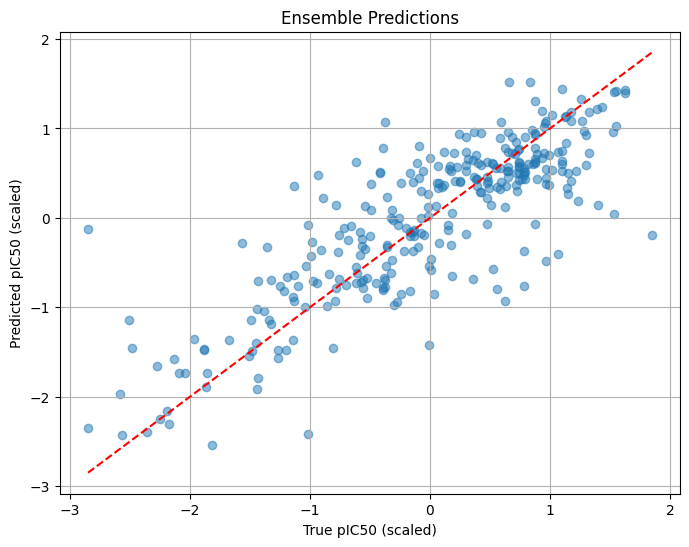


=== Model Performance Report ===

Dataset Size: 1513 compounds
pIC50 Range: 2.54 to 10.52

Model Performance:
GraphConv Model:
- R²: 0.664
- MAE: 0.440
- Training Time: 98.16431593894958s

Fingerprint Model:
- R²: 0.658
- MAE: 0.427
- Training Time: 1.3928115367889404s

Ensemble Model:
- R²: 0.673
- MAE: 0.408

=== BACE1 Affinity Prediction ===
Enter SMILES strings or 'quit' to exit




KeyboardInterrupt



In [87]:
def main():
    predictor = AffinityPredictor()
    try:
        logger.info("Starting data loading...")
        try:
            predictor.load_data(use_chembl=True)
        except Exception as e:
            logger.warning(f"Initial load failed, trying local only: {str(e)}")
            predictor.load_data(use_chembl=False)
        if hasattr(predictor, 'dataset_df') and len(predictor.dataset_df) >= 100:
            logger.info("Starting model training...")
            predictor.train_and_evaluate()
            predictor.report()
            predictor.interactive_predict()
        else:
            logger.error("Insufficient data for training (need at least 100 samples)")
            print("\nError: Not enough valid data for training (need at least 100 samples)")
    except Exception as e:
        logger.error(f"Fatal error: {str(e)}", exc_info=True)
        print(f"\nA critical error occurred: {str(e)}\n")

if __name__ == "__main__":
    main()